# CTMS Model Testing - CN vs CI Analysis

This notebook demonstrates:
1. Loading your data format
2. Training the CTMS model
3. Computing CN baseline statistics
4. Detecting anomalies in CI participants
5. Visualizing CN vs CI differences

**Expected Result**: CI participants should have significantly higher anomaly scores than CN participants.

## 1. Setup and Imports

In [4]:
#Install required packages (run once)
# !pip install torch torchvision
# !pip install torch-geometric
# !pip install fastdtw
# !pip install scipy numpy pandas matplotlib seaborn tqdm

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

2.3.1+cu121
False
12.1


/home/heming/anaconda3/envs/moments/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
import sys
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import defaultdict

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


In [3]:
# Import CTMS modules
# Make sure ctms_model_complete.py and ctms_data.py are in the same directory
from ctms_model import CTMSModel, compute_anomaly_scores
from ctms_data import CTMSDataset, collate_fn
from torch.utils.data import DataLoader

print("✓ CTMS modules imported successfully")

/home/heming/anaconda3/envs/moments/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


✓ CTMS modules imported successfully


## 2. Load and Explore Data

In [5]:
# Update these paths to your data files
SEQUENCE_FILE = '../sample_data/best_month_sequences.jsonl'  
LABEL_FILE = '../sample_data/subjects_public.json'       

# Check if files exist
if not os.path.exists(SEQUENCE_FILE):
    print(f"⚠️  File not found: {SEQUENCE_FILE}")
    print("Please update SEQUENCE_FILE path")
if not os.path.exists(LABEL_FILE):
    print(f"⚠️  File not found: {LABEL_FILE}")
    print("Please update LABEL_FILE path")
else:
    print("✓ Data files found")

✓ Data files found


In [6]:
# Load data
print("Loading data...")

# Load sequences
sequences = defaultdict(list)
with open(SEQUENCE_FILE, 'r') as f:
    for line in f:
        data = json.loads(line.strip())
        sequences[data['anon_id']].append(data)

# Load labels
with open(LABEL_FILE, 'r') as f:
    label_data = json.load(f)
    if isinstance(label_data, list):
        labels = {item['anon_id']: item for item in label_data}
    else:
        labels = label_data

print(f"✓ Loaded {len(sequences)} participants")
print(f"✓ Loaded {len(labels)} labels")

Loading data...
✓ Loaded 68 participants
✓ Loaded 68 labels


In [7]:
# Data statistics
cn_count = sum(1 for l in labels.values() if l['label'] == 'CN')
ci_count = sum(1 for l in labels.values() if l['label'] == 'CI')

print("\nDataset Statistics:")
print(f"  CN (Cognitively Normal): {cn_count}")
print(f"  CI (Cognitively Impaired): {ci_count}")
print(f"  Total participants: {cn_count + ci_count}")

# Check sequence lengths
seq_lengths = []
for anon_id, months in sequences.items():
    for month_data in months:
        seq_lengths.append(len(month_data['sequence']))

print(f"\nSequence length statistics:")
print(f"  Mean: {np.mean(seq_lengths):.1f}")
print(f"  Median: {np.median(seq_lengths):.1f}")
print(f"  Min: {np.min(seq_lengths)}")
print(f"  Max: {np.max(seq_lengths)}")


Dataset Statistics:
  CN (Cognitively Normal): 26
  CI (Cognitively Impaired): 42
  Total participants: 68

Sequence length statistics:
  Mean: 774.5
  Median: 551.0
  Min: 12
  Max: 2919


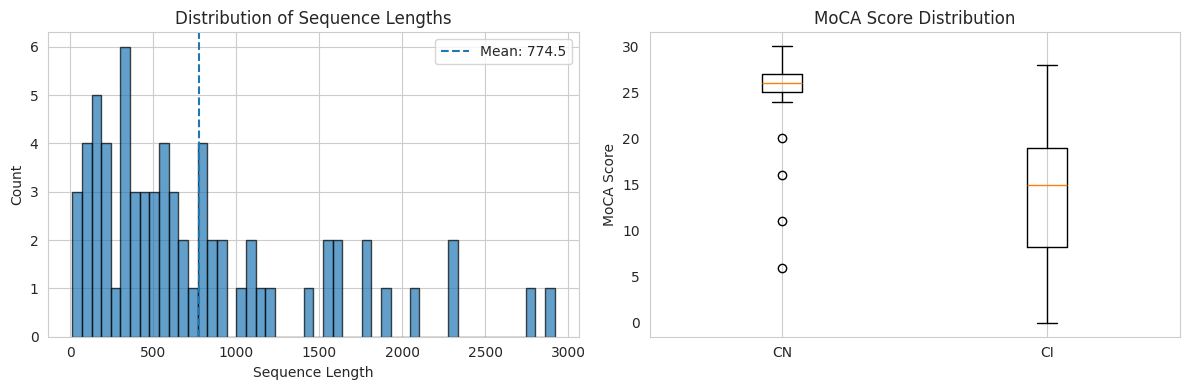

CN MoCA (n=22): 24.23 ± 5.86
CI MoCA (n=34): 14.32 ± 7.47


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def to_float_or_nan(x):
    if x is None:
        return np.nan
    if isinstance(x, str):
        x = x.strip()
        if x == '':
            return np.nan
    try:
        return float(x)
    except Exception:
        return np.nan

# 提取并清洗 MoCA
cn_moca_raw = [labels[aid]['scores'].get('moca', None)
               for aid in labels if labels[aid]['label'] == 'CN']
ci_moca_raw = [labels[aid]['scores'].get('moca', None)
               for aid in labels if labels[aid]['label'] == 'CI']

cn_moca = np.array([to_float_or_nan(v) for v in cn_moca_raw], dtype=float)
ci_moca = np.array([to_float_or_nan(v) for v in ci_moca_raw], dtype=float)

# 去掉 NaN 参与 boxplot
cn_moca_clean = cn_moca[~np.isnan(cn_moca)]
ci_moca_clean = ci_moca[~np.isnan(ci_moca)]

plt.figure(figsize=(12, 4))

# 左图：sequence length Histogram（如果你已有 seq_lengths，可保留原代码）
plt.subplot(1, 2, 1)
plt.hist(seq_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Distribution of Sequence Lengths')
plt.axvline(np.mean(seq_lengths), linestyle='--', label=f'Mean: {np.mean(seq_lengths):.1f}')
plt.legend()

# 右图：MoCA 箱线图
plt.subplot(1, 2, 2)
plt.boxplot([cn_moca_clean, ci_moca_clean], tick_labels=['CN', 'CI'])
plt.ylabel('MoCA Score')
plt.title('MoCA Score Distribution')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

print(f"CN MoCA (n={cn_moca_clean.size}): {np.nanmean(cn_moca):.2f} ± {np.nanstd(cn_moca):.2f}")
print(f"CI MoCA (n={ci_moca_clean.size}): {np.nanmean(ci_moca):.2f} ± {np.nanstd(ci_moca):.2f}")

## 3. Create Datasets and Dataloaders

In [9]:
# Create dataset
print("Creating datasets...")

dataset = CTMSDataset(
    sequence_file=SEQUENCE_FILE,
    label_file=LABEL_FILE,
    max_seq_len=500,  # Adjust based on your data
    min_seq_len=10
)

print(f"✓ Created dataset with {len(dataset)} samples")

Creating datasets...
Loaded 68 samples from 68 participants
✓ Created dataset with 68 samples


In [10]:
# Split dataset
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"\nDataset split:")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val:   {len(val_dataset)} samples")
print(f"  Test:  {len(test_dataset)} samples")


Dataset split:
  Train: 47 samples
  Val:   10 samples
  Test:  11 samples


In [11]:
# Create dataloaders
batch_size = 16  # Adjust based on your GPU memory

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0  # Set to 0 for Windows, 4 for Linux/Mac
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

print("✓ Dataloaders created")

✓ Dataloaders created


## 4. Initialize CTMS Model

In [13]:
# Initialize model
model = CTMSModel(
    d_model=128,
    num_activities=21,  # Your activity mapping has 21 activities (0-20)
    num_task_templates=20
)

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Device: {device}")

Model initialized:
  Total parameters: 5,468,291
  Trainable parameters: 5,468,291
  Device: cpu


## 5. Training

In [14]:
# Training configuration
num_epochs = 20  # Start with fewer epochs for testing
learning_rate = 1e-4

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.BCELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

print(f"Training configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Optimizer: AdamW")
print(f"  Loss: BCELoss")

Training configuration:
  Epochs: 20
  Learning rate: 0.0001
  Optimizer: AdamW
  Loss: BCELoss


/home/heming/anaconda3/envs/moments/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [15]:
# Training function
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for batch in pbar:
        activity_ids = batch['activity_ids'].to(device)
        timestamps = batch['timestamps'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(activity_ids, timestamps)
        
        loss = criterion(outputs['output'], labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = (outputs['output'] > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            activity_ids = batch['activity_ids'].to(device)
            timestamps = batch['timestamps'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(activity_ids, timestamps)
            loss = criterion(outputs['output'], labels)
            
            total_loss += loss.item()
            preds = (outputs['output'] > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Compute metrics
    accuracy = correct / total
    tp = ((all_preds == 1) & (all_labels == 1)).sum()
    fn = ((all_preds == 0) & (all_labels == 1)).sum()
    tn = ((all_preds == 0) & (all_labels == 0)).sum()
    fp = ((all_preds == 1) & (all_labels == 0)).sum()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return {
        'loss': total_loss / len(dataloader),
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity
    }

In [16]:
# Training loop
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_sensitivity': [],
    'val_specificity': []
}

best_val_loss = float('inf')

print("Starting training...\n")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    
    # Validate
    val_metrics = evaluate(model, val_loader, criterion, device)
    print(f"Val   - Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"        Sensitivity: {val_metrics['sensitivity']:.4f}, Specificity: {val_metrics['specificity']:.4f}")
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_sensitivity'].append(val_metrics['sensitivity'])
    history['val_specificity'].append(val_metrics['specificity'])
    
    # Learning rate scheduling
    scheduler.step(val_metrics['loss'])
    
    # Save best model
    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_metrics['loss'],
            'val_accuracy': val_metrics['accuracy']
        }, 'best_ctms_model.pt')
        print("✓ Saved best model")

print("\n" + "="*50)
print("Training completed!")
print("="*50)

Starting training...


Epoch 1/20
--------------------------------------------------


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Train - Loss: 0.6823, Accuracy: 0.5957


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Val   - Loss: 0.6876, Accuracy: 0.6000
        Sensitivity: 1.0000, Specificity: 0.0000
✓ Saved best model

Epoch 2/20
--------------------------------------------------


Training:   0%|          | 0/3 [00:00<?, ?it/s]

Train - Loss: 0.6914, Accuracy: 0.5957


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Val   - Loss: 0.6903, Accuracy: 0.6000
        Sensitivity: 1.0000, Specificity: 0.0000

Epoch 3/20
--------------------------------------------------


Training:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

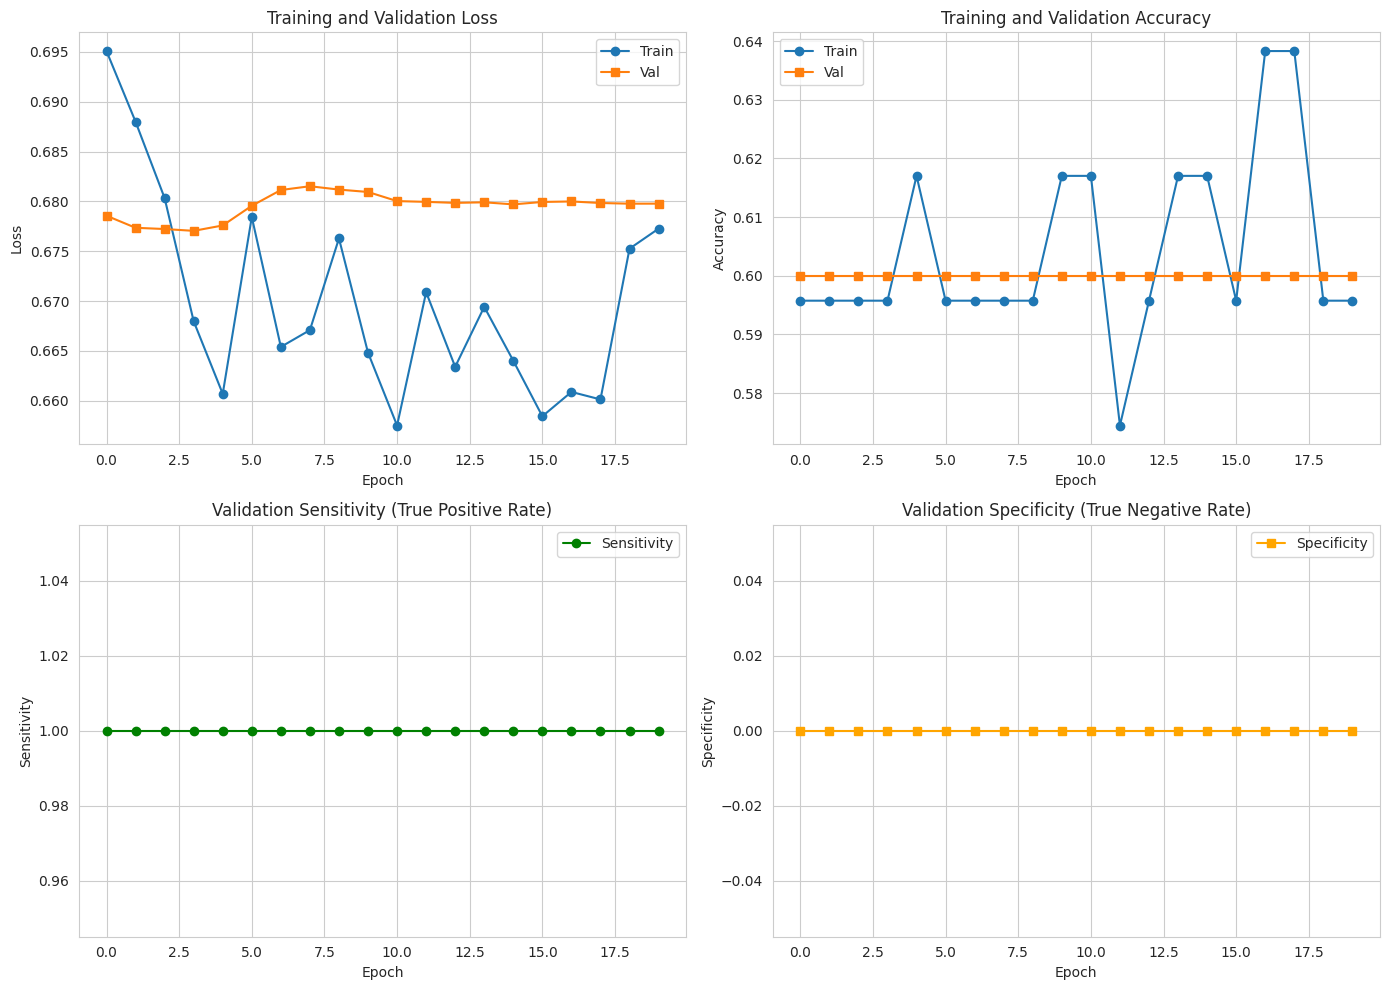


Final metrics:
  Best Val Loss: 0.6770
  Final Val Accuracy: 0.6000
  Final Val Sensitivity: 1.0000
  Final Val Specificity: 0.0000


In [21]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train', marker='o')
axes[0, 1].plot(history['val_acc'], label='Val', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Sensitivity
axes[1, 0].plot(history['val_sensitivity'], label='Sensitivity', marker='o', color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Sensitivity')
axes[1, 0].set_title('Validation Sensitivity (True Positive Rate)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Specificity
axes[1, 1].plot(history['val_specificity'], label='Specificity', marker='s', color='orange')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Specificity')
axes[1, 1].set_title('Validation Specificity (True Negative Rate)')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFinal metrics:")
print(f"  Best Val Loss: {best_val_loss:.4f}")
print(f"  Final Val Accuracy: {history['val_acc'][-1]:.4f}")
print(f"  Final Val Sensitivity: {history['val_sensitivity'][-1]:.4f}")
print(f"  Final Val Specificity: {history['val_specificity'][-1]:.4f}")

## 6. Compute CN Baseline Statistics

In [22]:
# Load best model
checkpoint = torch.load('best_ctms_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("✓ Loaded best model from checkpoint")
print(f"  Epoch: {checkpoint['epoch']}")
print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
print(f"  Val Accuracy: {checkpoint['val_accuracy']:.4f}")

✓ Loaded best model from checkpoint
  Epoch: 3
  Val Loss: 0.6770
  Val Accuracy: 0.6000


In [23]:
# Compute baseline statistics from CN participants in training set
print("\nComputing CN baseline statistics...")

all_h_c, all_h_t, all_h_m, all_h_s = [], [], [], []
cn_count = 0

model.eval()
with torch.no_grad():
    for batch in tqdm(train_loader, desc='Processing CN samples'):
        # Filter for CN samples (label == 0)
        cn_mask = batch['labels'] == 0
        if not cn_mask.any():
            continue
        
        activity_ids = batch['activity_ids'][cn_mask].to(device)
        timestamps = batch['timestamps'][cn_mask].to(device)
        
        # Get encodings
        outputs = model(activity_ids, timestamps, return_encodings_only=True)
        
        all_h_c.append(outputs['h_c'].cpu())
        all_h_t.append(outputs['h_t'].cpu())
        all_h_m.append(outputs['h_m'].cpu())
        all_h_s.append(outputs['h_s'].cpu())
        
        cn_count += activity_ids.size(0)

# Concatenate all encodings
all_h_c = torch.cat(all_h_c, dim=0)
all_h_t = torch.cat(all_h_t, dim=0)
all_h_m = torch.cat(all_h_m, dim=0)
all_h_s = torch.cat(all_h_s, dim=0)

# Compute statistics
baseline_stats = {
    'mean': {
        'h_c': all_h_c.mean(dim=0),
        'h_t': all_h_t.mean(dim=0),
        'h_m': all_h_m.mean(dim=0),
        'h_s': all_h_s.mean(dim=0)
    },
    'std': {
        'h_c': all_h_c.std(dim=0),
        'h_t': all_h_t.std(dim=0),
        'h_m': all_h_m.std(dim=0),
        'h_s': all_h_s.std(dim=0)
    }
}

# Save baseline statistics
torch.save(baseline_stats, 'baseline_stats.pt')

print(f"\n✓ Computed baseline statistics from {cn_count} CN samples")
print(f"✓ Saved to baseline_stats.pt")


Computing CN baseline statistics...


Processing CN samples:   0%|          | 0/3 [00:00<?, ?it/s]


✓ Computed baseline statistics from 19 CN samples
✓ Saved to baseline_stats.pt


In [25]:
with torch.no_grad():
    sample = next(iter(test_loader))
    outs = model(sample['activity_ids'].to(device),
                 sample['timestamps'].to(device),
                 return_encodings_only=True)

print("=== encodings ===")
for k, v in outs.items():
    if torch.is_tensor(v):
        print(f"{k:12s}", tuple(v.shape))
    else:
        try:
            print(f"{k:12s}", {kk: tuple(vv.shape) for kk, vv in v.items()})
        except Exception:
            print(f"{k:12s}", type(v))

print("\n=== baseline mean/std ===")
for k in baseline_stats['mean']:
    print("mean", k, tuple(baseline_stats['mean'][k].shape))
for k in baseline_stats['std']:
    print("std ", k, tuple(baseline_stats['std'][k].shape))

=== encodings ===
h_c          (11, 128)
h_t          (11, 128)
h_m          (11, 128)
h_s          (11, 128)
cdi          (11,)
tir          (11,)
me           (11,)
sws          (11,)

=== baseline mean/std ===
mean h_c (128,)
mean h_t (128,)
mean h_m (128,)
mean h_s (128,)
std  h_c (128,)
std  h_t (128,)
std  h_m (128,)
std  h_s (128,)


## 7. Compute Anomaly Scores - CN vs CI Comparison

In [26]:
# ==== imports & tqdm 安全导入（避免 IProgress 依赖报错） ====
import os
os.environ.setdefault("TQDM_NOTEBOOK", "0")  # 禁用 notebook 样式，避免 IProgress 依赖
try:
    from tqdm.auto import tqdm
except Exception:
    from tqdm import tqdm

import torch

# ==== 基线搬运到设备（保持原结构） ====
def to_device_baseline_stats(baseline_stats, device, dtype=None):
    """
    baseline_stats: {
        'mean': {'h_c': [128], 'h_t': [128], 'h_m': [128], 'h_s': [128]},
        'std' : {'h_c': [128], 'h_t': [128], 'h_m': [128], 'h_s': [128]}
    }
    """
    mean = {}
    std = {}
    for k, v in baseline_stats['mean'].items():
        vv = v.to(device)
        if dtype is not None:
            vv = vv.to(dtype)
        mean[k] = vv
    for k, v in baseline_stats['std'].items():
        vv = v.to(device)
        if dtype is not None:
            vv = vv.to(dtype)
        std[k] = vv
    return {'mean': mean, 'std': std}

# ==== 计算异常分（与每个 128 维子空间的基线对齐） ====
@torch.no_grad()
def compute_anomaly_scores(encodings, baseline_stats_device, alpha=None):
    """
    encodings: dict，包含四个128维编码：
        h_c/h_t/h_m/h_s: [B, 128]
      以及若干标量输出（可选，不参与对128维基线比较）：
        cdi/tir/me/sws: [B]
    baseline_stats_device: {'mean': {...}, 'std': {...}}，各键为 128 维

    返回：
      ad_scores: [B]，四个子空间分数的平均
      dim_scores: dict -> {'circadian': [B], 'task': [B], 'movement': [B], 'social': [B]}
    """
    key_map = {
        'h_c': 'circadian',
        'h_t': 'task',
        'h_m': 'movement',
        'h_s': 'social',
    }

    dim_scores = {}
    per_dim_scores = []

    for h_key, out_name in key_map.items():
        if h_key not in encodings:
            raise KeyError(f"encodings 缺少键: {h_key}")
        x = encodings[h_key]  # [B, 128]
        mu = baseline_stats_device['mean'][h_key]  # [128]
        sd = baseline_stats_device['std'][h_key].clamp_min(1e-6)  # [128]

        # 保证 device/dtype 与 x 一致
        mu = mu.to(x.device, dtype=x.dtype)
        sd = sd.to(x.device, dtype=x.dtype)

        z = (x - mu) / sd          # [B, 128] 广播
        score = (z ** 2).mean(1)   # [B]
        dim_scores[out_name] = score
        per_dim_scores.append(score)

    # 聚合：简单平均（可改为加权平均）
    ad_scores = torch.stack(per_dim_scores, dim=1).mean(1)  # [B]
    return ad_scores, dim_scores

# ==== 主流程：计算测试集所有样本的异常分并按 CN/CI 分桶 ====
print("Computing anomaly scores for test set...")

cn_scores = {
    'ad_score': [], 'circadian': [], 'task': [], 'movement': [], 'social': [],
    'cdi': [], 'tir': [], 'me': [], 'sws': []
}
ci_scores = {
    'ad_score': [], 'circadian': [], 'task': [], 'movement': [], 'social': [],
    'cdi': [], 'tir': [], 'me': [], 'sws': []
}

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Computing anomaly scores'):
        activity_ids = batch['activity_ids'].to(device)
        timestamps   = batch['timestamps'].to(device)
        labels_np    = batch['labels'].cpu().numpy()   # 0=CN, 1=CI（按你之前的代码）

        # 取编码/指标
        outputs = model(activity_ids, timestamps, return_encodings_only=True)
        # 形如：
        # outputs['h_c'], outputs['h_t'], outputs['h_m'], outputs['h_s']  -> [B,128]
        # outputs['cdi'], outputs['tir'], outputs['me'], outputs['sws']   -> [B]

        # 基线搬到同设备
        baseline_stats_device = to_device_baseline_stats(
            baseline_stats, device, dtype=outputs['h_c'].dtype
        )

        # 计算异常分
        ad_scores, dim_scores = compute_anomaly_scores(outputs, baseline_stats_device)

        # 逐样本写入
        B = len(labels_np)
        for i in range(B):
            sd = cn_scores if labels_np[i] == 0 else ci_scores

            # 总分 + 四个子空间分
            sd['ad_score'].append(ad_scores[i].detach().cpu().item())
            sd['circadian'].append(dim_scores['circadian'][i].detach().cpu().item())
            sd['task'].append(dim_scores['task'][i].detach().cpu().item())
            sd['movement'].append(dim_scores['movement'][i].detach().cpu().item())
            sd['social'].append(dim_scores['social'][i].detach().cpu().item())

            # 这四个是模型额外输出标量（若存在就记录）
            for aux_key in ['cdi', 'tir', 'me', 'sws']:
                if aux_key in outputs and torch.is_tensor(outputs[aux_key]):
                    sd[aux_key].append(outputs[aux_key][i].detach().cpu().item())

print(f"\n✓ Computed scores for:")
print(f"  CN samples: {len(cn_scores['ad_score'])}")
print(f"  CI samples: {len(ci_scores['ad_score'])}")

Computing anomaly scores for test set...


Computing anomaly scores:   0%|          | 0/1 [00:00<?, ?it/s]


✓ Computed scores for:
  CN samples: 3
  CI samples: 8


In [27]:
# Statistical comparison
from scipy import stats

print("\n" + "="*70)
print("CN vs CI Comparison - Anomaly Scores")
print("="*70)

metrics = ['ad_score', 'circadian', 'task', 'movement', 'social']
metric_names = ['AD Score', 'Circadian', 'Task', 'Movement', 'Social']

results_df = []

for metric, name in zip(metrics, metric_names):
    cn_vals = np.array(cn_scores[metric])
    ci_vals = np.array(ci_scores[metric])
    
    # Compute statistics
    cn_mean = np.mean(cn_vals)
    cn_std = np.std(cn_vals)
    ci_mean = np.mean(ci_vals)
    ci_std = np.std(ci_vals)
    
    # T-test
    t_stat, p_value = stats.ttest_ind(cn_vals, ci_vals)
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt((cn_std**2 + ci_std**2) / 2)
    cohens_d = (ci_mean - cn_mean) / pooled_std if pooled_std > 0 else 0
    
    results_df.append({
        'Metric': name,
        'CN Mean±SD': f"{cn_mean:.3f}±{cn_std:.3f}",
        'CI Mean±SD': f"{ci_mean:.3f}±{ci_std:.3f}",
        'Difference': f"{ci_mean - cn_mean:.3f}",
        'p-value': f"{p_value:.6f}",
        "Cohen's d": f"{cohens_d:.3f}"
    })
    
    print(f"\n{name}:")
    print(f"  CN: {cn_mean:.3f} ± {cn_std:.3f}")
    print(f"  CI: {ci_mean:.3f} ± {ci_std:.3f}")
    print(f"  Difference: {ci_mean - cn_mean:.3f} ({(ci_mean - cn_mean)/cn_mean*100:.1f}%)")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.6f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")
    print(f"  Cohen's d: {cohens_d:.3f} ({'large' if abs(cohens_d) > 0.8 else 'medium' if abs(cohens_d) > 0.5 else 'small'})")

# Create results table
results_df = pd.DataFrame(results_df)
print("\n" + "="*70)
print(results_df.to_string(index=False))
print("="*70)

# Save results
results_df.to_csv('cn_vs_ci_comparison.csv', index=False)
print("\n✓ Saved comparison to cn_vs_ci_comparison.csv")


CN vs CI Comparison - Anomaly Scores

AD Score:
  CN: 2.878 ± 2.268
  CI: 0.865 ± 1.027
  Difference: -2.014 (-70.0%)
  t-statistic: 1.826
  p-value: 0.101056 ns
  Cohen's d: -1.144 (large)

Circadian:
  CN: 1.454 ± 0.909
  CI: 0.999 ± 0.882
  Difference: -0.455 (-31.3%)
  t-statistic: 0.683
  p-value: 0.511814 ns
  Cohen's d: -0.508 (medium)

Task:
  CN: 1.256 ± 0.571
  CI: 1.145 ± 1.667
  Difference: -0.110 (-8.8%)
  t-statistic: 0.101
  p-value: 0.921444 ns
  Cohen's d: -0.088 (small)

Movement:
  CN: 1.484 ± 1.024
  CI: 1.139 ± 1.567
  Difference: -0.345 (-23.3%)
  t-statistic: 0.321
  p-value: 0.755757 ns
  Cohen's d: -0.261 (small)

Social:
  CN: 7.319 ± 10.183
  CI: 0.175 ± 0.058
  Difference: -7.144 (-97.6%)
  t-statistic: 1.795
  p-value: 0.106255 ns
  Cohen's d: -0.992 (large)

   Metric   CN Mean±SD  CI Mean±SD Difference  p-value Cohen's d
 AD Score  2.878±2.268 0.865±1.027     -2.014 0.101056    -1.144
Circadian  1.454±0.909 0.999±0.882     -0.455 0.511814    -0.508
     

## 8. Visualization - CN vs CI

/tmp/ipykernel_1732422/1921882953.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([cn_vals, ci_vals], labels=['CN', 'CI'],
/tmp/ipykernel_1732422/1921882953.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([cn_vals, ci_vals], labels=['CN', 'CI'],
/tmp/ipykernel_1732422/1921882953.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([cn_vals, ci_vals], labels=['CN', 'CI'],
/tmp/ipykernel_1732422/1921882953.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be 

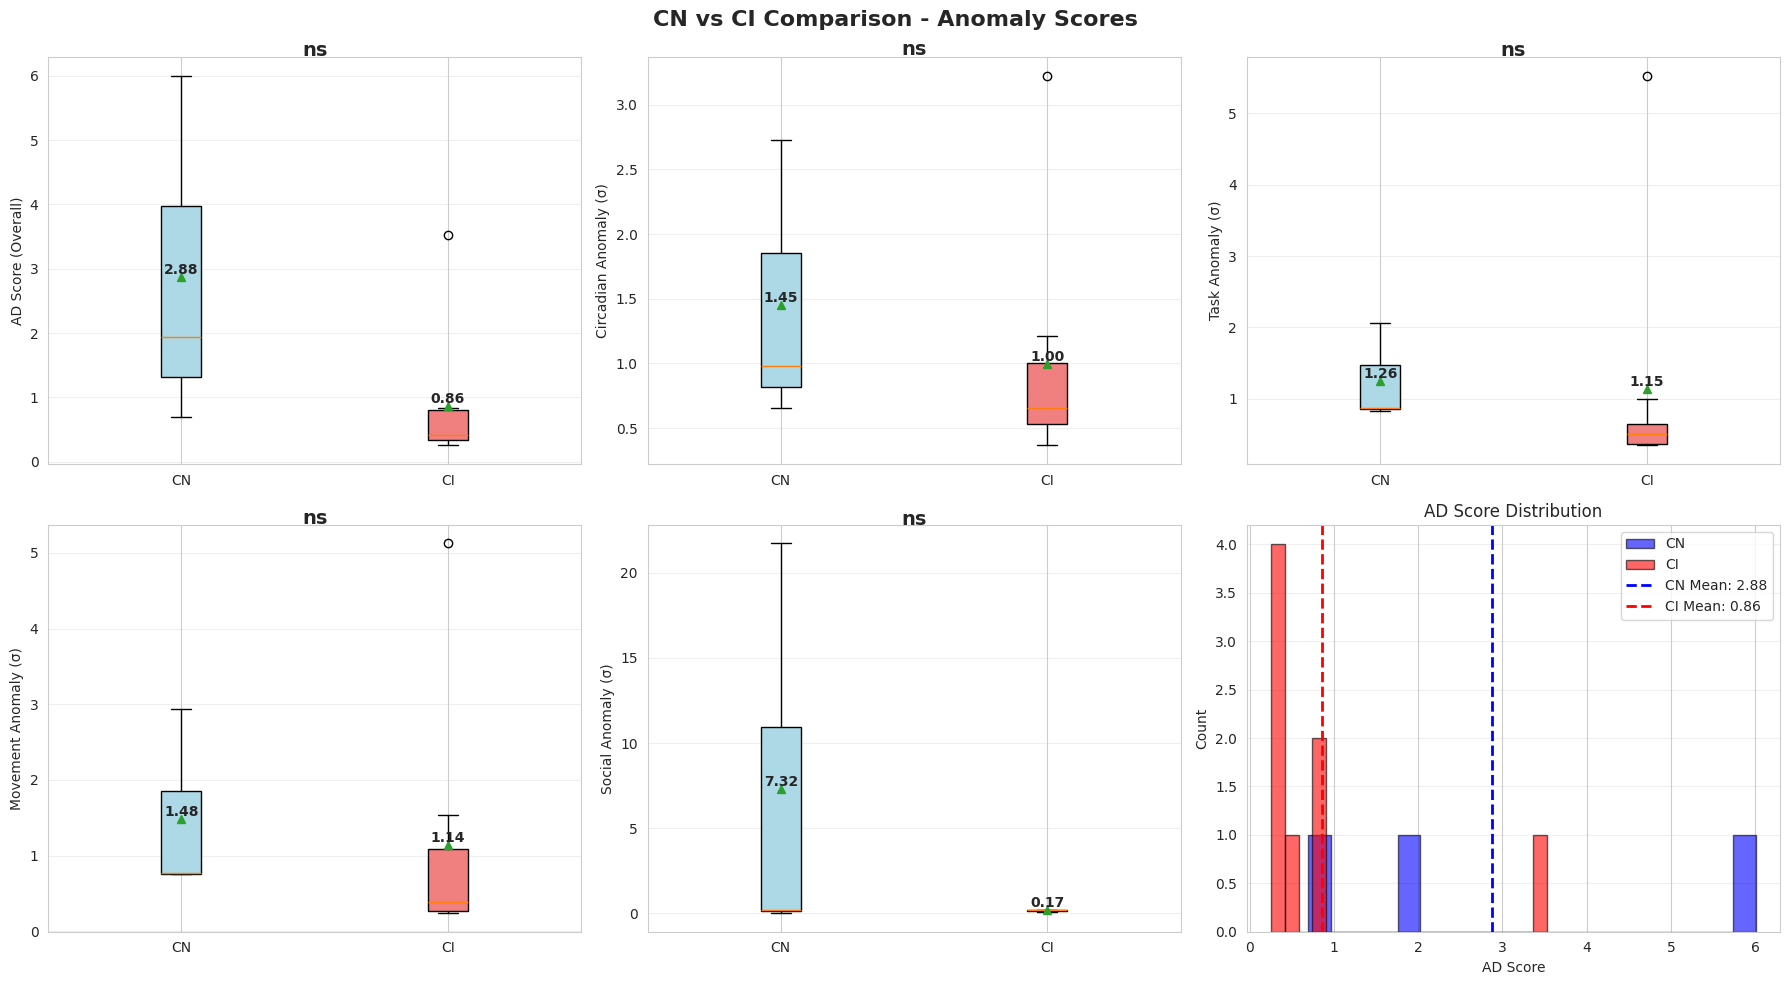

✓ Saved visualization to cn_vs_ci_comparison.png


In [28]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('CN vs CI Comparison - Anomaly Scores', fontsize=16, fontweight='bold')

metrics_to_plot = [
    ('ad_score', 'AD Score (Overall)', axes[0, 0]),
    ('circadian', 'Circadian Anomaly (σ)', axes[0, 1]),
    ('task', 'Task Anomaly (σ)', axes[0, 2]),
    ('movement', 'Movement Anomaly (σ)', axes[1, 0]),
    ('social', 'Social Anomaly (σ)', axes[1, 1])
]

for metric, title, ax in metrics_to_plot:
    cn_vals = cn_scores[metric]
    ci_vals = ci_scores[metric]
    
    # Box plot
    bp = ax.boxplot([cn_vals, ci_vals], labels=['CN', 'CI'],
                     patch_artist=True, showmeans=True)
    
    # Color boxes
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax.set_ylabel(title)
    ax.grid(axis='y', alpha=0.3)
    
    # Add mean values as text
    cn_mean = np.mean(cn_vals)
    ci_mean = np.mean(ci_vals)
    ax.text(1, cn_mean, f'{cn_mean:.2f}', ha='center', va='bottom', fontweight='bold')
    ax.text(2, ci_mean, f'{ci_mean:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Add significance stars
    _, p_val = stats.ttest_ind(cn_vals, ci_vals)
    if p_val < 0.001:
        sig = '***'
    elif p_val < 0.01:
        sig = '**'
    elif p_val < 0.05:
        sig = '*'
    else:
        sig = 'ns'
    
    y_max = max(max(cn_vals), max(ci_vals))
    ax.text(1.5, y_max * 1.05, sig, ha='center', fontsize=14, fontweight='bold')

# Combined histogram in last subplot
ax = axes[1, 2]
ax.hist(cn_scores['ad_score'], bins=20, alpha=0.6, label='CN', color='blue', edgecolor='black')
ax.hist(ci_scores['ad_score'], bins=20, alpha=0.6, label='CI', color='red', edgecolor='black')
ax.axvline(np.mean(cn_scores['ad_score']), color='blue', linestyle='--', linewidth=2, label=f'CN Mean: {np.mean(cn_scores["ad_score"]):.2f}')
ax.axvline(np.mean(ci_scores['ad_score']), color='red', linestyle='--', linewidth=2, label=f'CI Mean: {np.mean(ci_scores["ad_score"]):.2f}')
ax.set_xlabel('AD Score')
ax.set_ylabel('Count')
ax.set_title('AD Score Distribution')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('cn_vs_ci_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved visualization to cn_vs_ci_comparison.png")

/home/heming/anaconda3/envs/moments/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


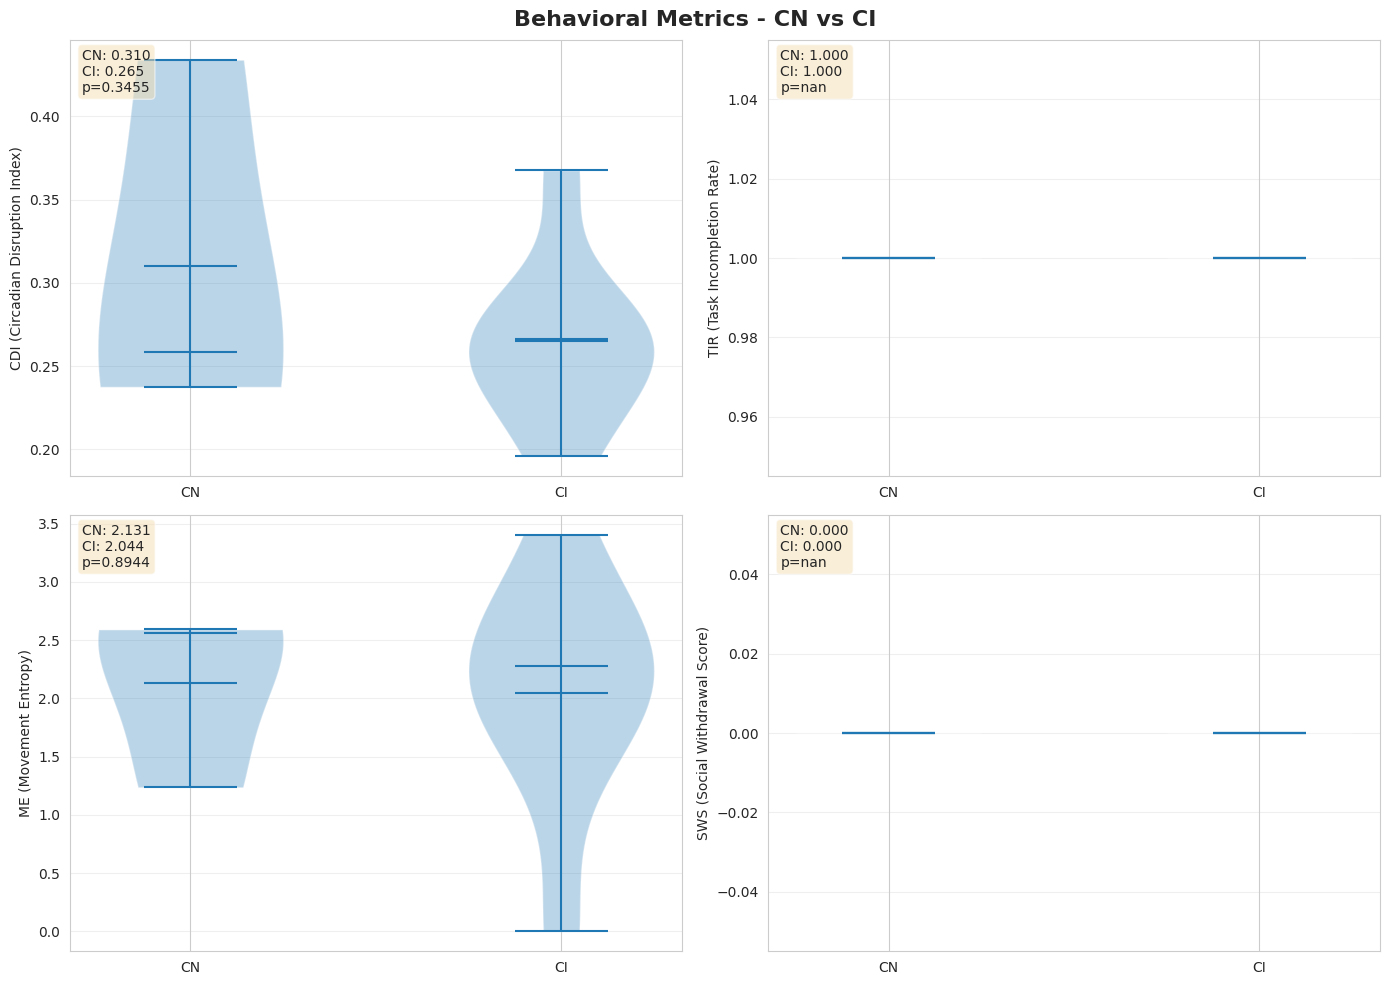

✓ Saved behavioral metrics visualization


In [29]:
# Behavioral metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Behavioral Metrics - CN vs CI', fontsize=16, fontweight='bold')

behavioral_metrics = [
    ('cdi', 'CDI (Circadian Disruption Index)', axes[0, 0]),
    ('tir', 'TIR (Task Incompletion Rate)', axes[0, 1]),
    ('me', 'ME (Movement Entropy)', axes[1, 0]),
    ('sws', 'SWS (Social Withdrawal Score)', axes[1, 1])
]

for metric, title, ax in behavioral_metrics:
    cn_vals = cn_scores[metric]
    ci_vals = ci_scores[metric]
    
    # Violin plot
    parts = ax.violinplot([cn_vals, ci_vals], positions=[1, 2],
                          showmeans=True, showmedians=True)
    
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['CN', 'CI'])
    ax.set_ylabel(title)
    ax.grid(axis='y', alpha=0.3)
    
    # Add statistics
    cn_mean = np.mean(cn_vals)
    ci_mean = np.mean(ci_vals)
    _, p_val = stats.ttest_ind(cn_vals, ci_vals)
    
    stats_text = f"CN: {cn_mean:.3f}\nCI: {ci_mean:.3f}\np={p_val:.4f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            va='top', ha='left', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('behavioral_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved behavioral metrics visualization")

## 9. ROC Curve Analysis

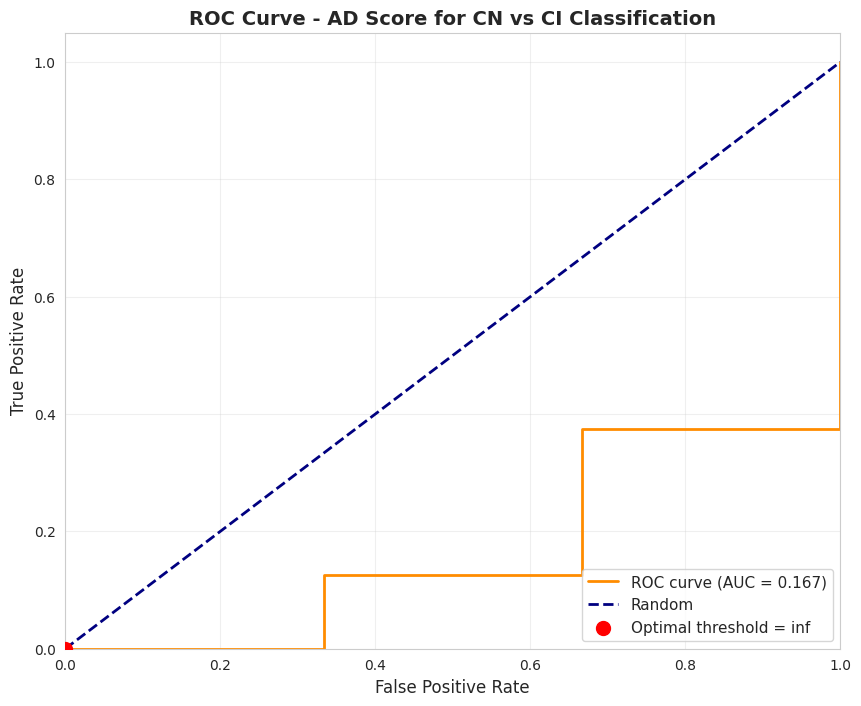

ROC Analysis:
  AUC: 0.1667
  Optimal threshold: inf
  Sensitivity at optimal: 0.0000
  Specificity at optimal: 1.0000
  Accuracy at optimal: 0.2727


In [31]:
from sklearn.metrics import roc_curve, auc

# Prepare data for ROC
y_true = [0] * len(cn_scores['ad_score']) + [1] * len(ci_scores['ad_score'])
y_scores = cn_scores['ad_score'] + ci_scores['ad_score']

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Find optimal threshold (Youden's index)
youdens_index = tpr - fpr
optimal_idx = np.argmax(youdens_index)
optimal_threshold = thresholds[optimal_idx]

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, zorder=5,
           label=f'Optimal threshold = {optimal_threshold:.3f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - AD Score for CN vs CI Classification', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"ROC Analysis:")
print(f"  AUC: {roc_auc:.4f}")
print(f"  Optimal threshold: {optimal_threshold:.4f}")
print(f"  Sensitivity at optimal: {tpr[optimal_idx]:.4f}")
print(f"  Specificity at optimal: {1-fpr[optimal_idx]:.4f}")

# Classification at optimal threshold
y_pred = [1 if score > optimal_threshold else 0 for score in y_scores]
accuracy = np.mean([y_p == y_t for y_p, y_t in zip(y_pred, y_true)])
print(f"  Accuracy at optimal: {accuracy:.4f}")

## 10. Summary and Conclusions

In [32]:
# Generate final summary
print("\n" + "="*80)
print("CTMS MODEL VALIDATION SUMMARY")
print("="*80)

print("\n1. TRAINING PERFORMANCE")
print("-" * 80)
print(f"   Best Validation Loss: {best_val_loss:.4f}")
print(f"   Final Accuracy: {history['val_acc'][-1]:.4f}")
print(f"   Final Sensitivity: {history['val_sensitivity'][-1]:.4f}")
print(f"   Final Specificity: {history['val_specificity'][-1]:.4f}")

print("\n2. ANOMALY SCORE COMPARISON (CN vs CI)")
print("-" * 80)
cn_ad_mean = np.mean(cn_scores['ad_score'])
ci_ad_mean = np.mean(ci_scores['ad_score'])
_, p_val = stats.ttest_ind(cn_scores['ad_score'], ci_scores['ad_score'])

print(f"   CN AD Score: {cn_ad_mean:.3f} ± {np.std(cn_scores['ad_score']):.3f}")
print(f"   CI AD Score: {ci_ad_mean:.3f} ± {np.std(ci_scores['ad_score']):.3f}")
print(f"   Difference: {ci_ad_mean - cn_ad_mean:.3f} ({(ci_ad_mean/cn_ad_mean - 1)*100:.1f}% increase)")
print(f"   Statistical significance: p = {p_val:.6f} {'***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'}")

print("\n3. DIMENSIONAL ANALYSIS")
print("-" * 80)
for dim in ['circadian', 'task', 'movement', 'social']:
    cn_mean = np.mean(cn_scores[dim])
    ci_mean = np.mean(ci_scores[dim])
    increase = (ci_mean / cn_mean - 1) * 100 if cn_mean > 0 else 0
    _, p = stats.ttest_ind(cn_scores[dim], ci_scores[dim])
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    print(f"   {dim.capitalize():12s}: CN={cn_mean:.3f}, CI={ci_mean:.3f}, +{increase:.1f}% ({sig})")

print("\n4. BEHAVIORAL METRICS")
print("-" * 80)
for metric, name in [('cdi', 'Circadian Disruption'), ('tir', 'Task Incompletion'), 
                      ('me', 'Movement Entropy'), ('sws', 'Social Withdrawal')]:
    cn_mean = np.mean(cn_scores[metric])
    ci_mean = np.mean(ci_scores[metric])
    _, p = stats.ttest_ind(cn_scores[metric], ci_scores[metric])
    sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
    print(f"   {name:22s}: CN={cn_mean:.3f}, CI={ci_mean:.3f} ({sig})")

print("\n5. ROC ANALYSIS")
print("-" * 80)
print(f"   AUC: {roc_auc:.4f}")
print(f"   Optimal Threshold: {optimal_threshold:.4f}")
print(f"   Sensitivity: {tpr[optimal_idx]:.4f}")
print(f"   Specificity: {1-fpr[optimal_idx]:.4f}")

print("\n6. CONCLUSION")
print("-" * 80)
if ci_ad_mean > cn_ad_mean and p_val < 0.05:
    print("   ✅ MODEL VALIDATION SUCCESSFUL")
    print(f"   ✅ CI participants show significantly higher anomaly scores than CN")
    print(f"   ✅ Mean difference: {ci_ad_mean - cn_ad_mean:.3f} (p < {p_val:.4f})")
    print(f"   ✅ The CTMS model can effectively distinguish between CN and CI")
else:
    print("   ⚠️  Results are not statistically significant")
    print("   ⚠️  Consider: 1) More training epochs, 2) More data, 3) Hyperparameter tuning")

print("\n" + "="*80)
print("✓ Analysis complete! All results and visualizations saved.")
print("="*80)


CTMS MODEL VALIDATION SUMMARY

1. TRAINING PERFORMANCE
--------------------------------------------------------------------------------
   Best Validation Loss: 0.6770
   Final Accuracy: 0.6000
   Final Sensitivity: 1.0000
   Final Specificity: 0.0000

2. ANOMALY SCORE COMPARISON (CN vs CI)
--------------------------------------------------------------------------------
   CN AD Score: 2.878 ± 2.268
   CI AD Score: 0.865 ± 1.027
   Difference: -2.014 (-70.0% increase)
   Statistical significance: p = 0.101056 ns

3. DIMENSIONAL ANALYSIS
--------------------------------------------------------------------------------
   Circadian   : CN=1.454, CI=0.999, +-31.3% (ns)
   Task        : CN=1.256, CI=1.145, +-8.8% (ns)
   Movement    : CN=1.484, CI=1.139, +-23.3% (ns)
   Social      : CN=7.319, CI=0.175, +-97.6% (ns)

4. BEHAVIORAL METRICS
--------------------------------------------------------------------------------
   Circadian Disruption  : CN=0.310, CI=0.265 (ns)
   Task Incompletion 

/home/heming/anaconda3/envs/moments/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [33]:
# List all output files
print("\nGenerated files:")
output_files = [
    'best_ctms_model.pt',
    'baseline_stats.pt',
    'training_history.png',
    'cn_vs_ci_comparison.png',
    'cn_vs_ci_comparison.csv',
    'behavioral_metrics_comparison.png',
    'roc_curve.png'
]

for f in output_files:
    if os.path.exists(f):
        size = os.path.getsize(f) / 1024
        print(f"  ✓ {f} ({size:.1f} KB)")
    else:
        print(f"  ✗ {f} (not found)")


Generated files:
  ✓ best_ctms_model.pt (55632.6 KB)
  ✓ baseline_stats.pt (7.0 KB)
  ✓ training_history.png (175.2 KB)
  ✓ cn_vs_ci_comparison.png (133.2 KB)
  ✓ cn_vs_ci_comparison.csv (0.3 KB)
  ✓ behavioral_metrics_comparison.png (140.4 KB)
  ✓ roc_curve.png (75.1 KB)
